# Credit Risk Prediction Model 

### Business Needs

> To predict credit risk for customers applying for credit cards, enabling financial institutions to identify high-risk customers, reduce defaults, and optimize credit card approval decisions.


### Objective 

> To develop a machine learning model that predicts the likelihood of customer default using payment history and demographic data.

### Dataset Description
Source: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data

The dataset consists of two components sourced from Kaggle:
> - `Application Record`: A dataset with 438,557 records and 18 features, offering insights into customer demographics and credit card applications.
> - `Credit Record`: A dataset with 1,048,575 records and 3 features, capturing historical credit payment statuses for risk assessment.

###  Import Libraries and Load Data


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
application = pd.read_csv("application_record.csv")
credit = pd.read_csv("credit_record.csv")

In [3]:
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
credit.tail()

,ID,MONTHS_BALANCE,STATUS
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C
1048574,5150487,-29,C


In [5]:
print('Application Record:')
print(f'No. of records: {application.shape[0]}')
print(f'No. of features: {application.shape[1]}')
print()
print('Credit Record:')
print(f'No. of records: {credit.shape[0]}')
print(f'No. of features: {credit.shape[1]}')

Application Record:
No. of records: 438557
No. of features: 18

Credit Record:
No. of records: 1048575
No. of features: 3


In [6]:
print('Application basic summary:')
print(application.info())
print()
print('Credit basic summary:')
print(credit.info())

Application basic summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int

### Data Preparation and Initial Calculations

Group and organize account activity data by customer (ID).

In [7]:
# Group data by 'ID'
grouped_data = credit.groupby('ID')

### Calculate Account Timeline

Determine when accounts were opened, closed, and how long they were observed.

**account_open_month:**
- The first month an account was observed (or opened).
- Useful for tracking customer tenure and account life cycles.

**account_end_month:**
- The most recent month the account was active (could indicate account closure or last observed activity).

**observation_window:**
- The total number of months the account was tracked, calculated as the difference between account_end_month and account_open_month.
- This helps assess how long the account has been monitored, which is crucial for evaluating customer credit behavior over time.


In [8]:
# Convert data to wide format: each 'ID' becomes a row
pivot_table = credit.pivot(index='ID', columns='MONTHS_BALANCE', values='STATUS')

# Calculate 'account_open_month' and 'account_end_month' for each ID
pivot_table['account_open_month'] = grouped_data['MONTHS_BALANCE'].min()
pivot_table['account_end_month'] = grouped_data['MONTHS_BALANCE'].max()  # Largest value of 'MONTHS_BALANCE'

# Add 'ID' as a column and rearrange
pivot_table['ID'] = pivot_table.index
pivot_table = pivot_table[['ID', 'account_open_month', 'account_end_month']]

# Calculate the observation window
pivot_table['observation_window'] = pivot_table['account_end_month'] - pivot_table['account_open_month']

# Reset index of the pivot table
pivot_table.reset_index(drop=True, inplace=True)

# Merge calculated information back to the original DataFrame
credit = pd.merge(credit, pivot_table, on='ID', how='left')
credit.head()

,ID,MONTHS_BALANCE,STATUS,account_open_month,account_end_month,observation_window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18


### Analyze Overdue Accounts

- Identifies overdue accounts:
    - `overdue_flag` = 1: Overdue (indicating >60 days past due).
    - `overdue_flag` = 0: Not overdue.

- Calculates `months_since_open` to track the timeline of each account.

In [9]:
# Analyze overdue accounts: overdue_flag = 1 for overdue (> 60 days past due), otherwise 0
credit['overdue_flag'] = np.where(credit['STATUS'].isin(['2', '3', '4', '5']), 1, 0)
credit['overdue_flag'] = credit['overdue_flag'].astype(np.int8)

# Calculate 'months_since_open': months since the account was opened
credit['months_since_open'] = credit['MONTHS_BALANCE'] - credit['account_open_month']

# Sort data by 'ID' and 'months_since_open'
credit.sort_values(by=['ID', 'months_since_open'], inplace=True)

credit.head()

,ID,MONTHS_BALANCE,STATUS,account_open_month,account_end_month,observation_window,overdue_flag,months_since_open
3,5001711,-3,0,-3,0,3,0,0
2,5001711,-2,0,-3,0,3,0,1
1,5001711,-1,0,-3,0,3,0,2
0,5001711,0,X,-3,0,3,0,3
22,5001712,-18,0,-18,0,18,0,0


### Understanding Account Opening Trends
Objective: Analyze when customers opened their accounts.

- Groups accounts by their account_open_month to count the number of accounts opened during each month.
- Useful for identifying trends in account activity.

In [10]:
# Count how many users opened accounts in each month
accounts_by_open_month = pivot_table.groupby(['account_open_month']).agg({'ID': 'count'}).reset_index()
accounts_by_open_month.columns = ['account_open_month', 'account_count']

# Display the accounts_by_open_month table
accounts_by_open_month.head()

,account_open_month,account_count
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470


### Customer Segmentation

Objective: Categorize customers as high-risk (overdue) or low-risk (not overdue).


**High Risk Customers (overdue_accounts):**
- Includes customers who have experienced at least one overdue payment.
- Risk Status = 1: High-risk customers with overdue payments.

**Low Risk Customers (non_overdue_accounts):**
- Includes customers who have never had overdue payments.
- Risk Status = 0: Low-risk customers with no overdue payments.

In [11]:
# Calculate the maximum overdue_flag per ID
credit['Risk Status'] = credit.groupby('ID')['overdue_flag'].transform('max')
# Split the data into overdue (overdue_accounts) and not overdue (non_overdue_accounts)
overdue_accounts = credit.loc[credit['Risk Status'] == 1]
non_overdue_accounts = credit.loc[credit['Risk Status'] == 0]

### Summarize Overdue and Non-Overdue Accounts

Calculate key metrics for overdue and non-overdue customers.

**Non-Overdue Customers:**
- For customers with no overdue payments (Risk Status = 0):
    - months_since_open (max):
        - Captures the total duration of account activity for low-risk customers.

**Overdue Customers:**
- For customers with overdue payments (Risk Status = 1):
    - months_since_open (min):
        - Captures the month when the customer first became overdue. This helps pinpoint when their risk profile changed.

In [12]:
# Group non-overdue accounts and get the maximum 'months_since_open' and 'max_overdue_flag'
non_overdue_summary = non_overdue_accounts.groupby('ID').agg({
    'months_since_open': 'max',
    'Risk Status': 'max'
}).reset_index()
non_overdue_summary.columns = ['ID', 'months_since_open', 'Risk Status']

# Group overdue accounts and get the minimum 'months_since_open' for the first overdue occurrence
overdue_summary = overdue_accounts.loc[overdue_accounts['overdue_flag'] == 1].groupby('ID').agg({
    'months_since_open': 'min',
    'Risk Status': 'max'
}).reset_index()
overdue_summary.columns = ['ID', 'months_since_open', 'Risk Status']

###  Final Output: Customer Risk Profile
Objective: Combine high-risk and low-risk summaries into a single dataset.

In [13]:
# Concatenate both datasets to create a combined summary
customer_summary = pd.concat([non_overdue_summary, overdue_summary], ignore_index=True)

# Display the final combined DataFrame
customer_summary

,ID,months_since_open,Risk Status
0,5001711,3,0
1,5001712,18,0
2,5001713,21,0
3,5001714,14,0
4,5001715,59,0
...,...,...,...
45980,5149834,8,1
45981,5149838,8,1
45982,5150049,9,1
45983,5150238,48,1


### Merge Datasets & Handle Missing Values
Combine the summarized credit data with the application data and handle missing values.

In [14]:
df = pd.merge(customer_summary, application, on = 'ID', how = 'left')
df

,ID,months_since_open,Risk Status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5001711,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5001712,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5001713,21,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5001714,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5001715,59,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5149834,8,1,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0
45981,5149838,8,1,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0
45982,5150049,9,1,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0
45983,5150238,48,1,F,Y,Y,0.0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-19084.0,-128.0,1.0,1.0,0.0,0.0,Laborers,2.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   45985 non-null  int64  
 1   months_since_open    45985 non-null  int64  
 2   Risk Status          45985 non-null  int8   
 3   CODE_GENDER          36457 non-null  object 
 4   FLAG_OWN_CAR         36457 non-null  object 
 5   FLAG_OWN_REALTY      36457 non-null  object 
 6   CNT_CHILDREN         36457 non-null  float64
 7   AMT_INCOME_TOTAL     36457 non-null  float64
 8   NAME_INCOME_TYPE     36457 non-null  object 
 9   NAME_EDUCATION_TYPE  36457 non-null  object 
 10  NAME_FAMILY_STATUS   36457 non-null  object 
 11  NAME_HOUSING_TYPE    36457 non-null  object 
 12  DAYS_BIRTH           36457 non-null  float64
 13  DAYS_EMPLOYED        36457 non-null  float64
 14  FLAG_MOBIL           36457 non-null  float64
 15  FLAG_WORK_PHONE      36457 non-null 

In [16]:
df.isnull().sum()

ID                         0
months_since_open          0
Risk Status                0
CODE_GENDER             9528
FLAG_OWN_CAR            9528
FLAG_OWN_REALTY         9528
CNT_CHILDREN            9528
AMT_INCOME_TOTAL        9528
NAME_INCOME_TYPE        9528
NAME_EDUCATION_TYPE     9528
NAME_FAMILY_STATUS      9528
NAME_HOUSING_TYPE       9528
DAYS_BIRTH              9528
DAYS_EMPLOYED           9528
FLAG_MOBIL              9528
FLAG_WORK_PHONE         9528
FLAG_PHONE              9528
FLAG_EMAIL              9528
OCCUPATION_TYPE        20851
CNT_FAM_MEMBERS         9528
dtype: int64

In [17]:
df.dropna(inplace=True)

### Statistical Exploration

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,25134.0,5.078838e+06,41941.018788,5008806.0,5042228.25,5079004.0,5115603.75,5150487.0
months_since_open,25134.0,2.002797e+01,14.729175,0.0,8.00,16.0,30.00,60.0
Risk Status,25134.0,1.679001e-02,0.128486,0.0,0.00,0.0,0.00,1.0
CNT_CHILDREN,25134.0,5.123339e-01,0.787785,0.0,0.00,0.0,1.00,19.0
AMT_INCOME_TOTAL,25134.0,1.948339e+05,104510.987243,27000.0,135000.00,180000.0,225000.00,1575000.0
DAYS_BIRTH,25134.0,-1.479404e+04,3486.969790,-24611.0,-17438.00,-14547.0,-11964.00,-7489.0
DAYS_EMPLOYED,25134.0,-2.624941e+03,2339.224822,-15713.0,-3484.00,-1942.0,-979.00,-17.0
FLAG_MOBIL,25134.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.00,1.0
FLAG_WORK_PHONE,25134.0,2.738124e-01,0.445923,0.0,0.00,0.0,1.00,1.0
FLAG_PHONE,25134.0,2.927906e-01,0.455052,0.0,0.00,0.0,1.00,1.0


### Risk Status Distribution

The `Risk Status Distribution` barplot reveals a significant class imbalance, with 98.32% of customers classified as low risk (0) and only 1.68% as high risk (1). This disparity can skew machine learning models toward predicting the majority class, compromising their ability to detect high-risk customers. To mitigate this, suitable methods will be implemented to handle the imbalance effectively.

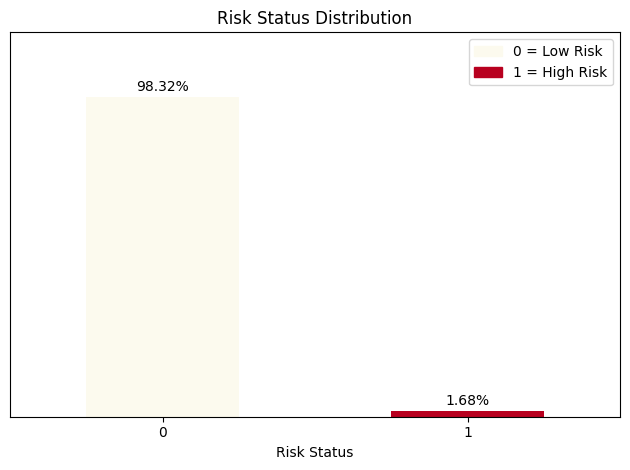

In [19]:
# Calculate the value counts and percentages
value_counts = df['Risk Status'].value_counts()
percentages = (value_counts / value_counts.sum()) * 100

# Customizing the bar chart to make "1" red and others default
colors = ['#B8001F' if index == 1 else '#FCFAEE' for index in value_counts.index]

# Plot the bar chart
ax = value_counts.plot(kind='bar', color=colors)

# Annotate each bar with the percentage
for i, count in enumerate(value_counts):
    percentage = f"{percentages[i]:.2f}%"
    ax.text(i, count + 500, percentage, ha='center', fontsize=10)  # Adjusts the text position

# Set y-axis limit
plt.ylim(0, value_counts.max() + 5000)  # Increases y-axis limit for better visibility

# Remove y-axis ticks
plt.yticks([])

# Add titles and labels
plt.title('Risk Status Distribution')
plt.xlabel('Risk Status')
plt.ylabel('')
plt.xticks(rotation=0)

# Create custom legend patches
low_risk_patch = mpatches.Patch(color='#FCFAEE', label='0 = Low Risk')
high_risk_patch = mpatches.Patch(color='#B8001F', label='1 = High Risk')

# Add legend
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')


plt.tight_layout();

## Feature Selection using Random Forest Importance Score

- Purpose: Utilize Random Forest to determine the most important features for predicting risk status.

- Approach: Features with importance scores above the average were selected for modeling, while irrelevant features, such as `ID`, were excluded as they do not contribute meaningful insights to the analysis.

- Outcome: The feature importance analysis highlighted the top contributors to risk status prediction: `months_since_open`, `DAYS_EMPLOYED`, `DAYS_BIRTH`, `AMT_INCOME_TOTAL`, and `OCCUPATION_TYPE`. These features effectively capture customer behavior and demographic characteristics essential for assessing credit risk.

In [20]:
df = df.drop(columns='ID')

In [21]:
df1 = df.copy()

### Encode Categorical Features

Convert categorical columns into numeric format for modeling.

Ordinal Encoding:
- Encodes `NAME_EDUCATION_TYPE` based on an educational hierarchy.

Label Encoding:
- Converts categorical columns into numeric codes.

In [22]:
df.select_dtypes(include='object').columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')

In [23]:
# Define the order for ordinal encoding
education_order = [
    'Lower secondary',
    'Secondary / secondary special',
    'Incomplete higher',
    'Higher education',
    'Academic degree'
]

# Apply ordinal encoding using a mapping
education_mapping = {level: idx for idx, level in enumerate(education_order)}
df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map(education_mapping)

In [24]:
# Columns to apply label encoding
columns_to_encode = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
    'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
]

# Initialize the LabelEncoder
label_encoders = {}

# Apply Label Encoding to each specified column
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()  # Store encoders for future use
    df[column] = label_encoders[column].fit_transform(df[column])

In [25]:
# Split the data into features and target
X = df.drop(columns=['Risk Status'])
y = df['Risk Status']

In [26]:
# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Fit the model to the data
rf.fit(X, y)

# Retrieve feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:\n", importance_df)

Feature Importances:
                 Feature  Importance
0     months_since_open    0.230500
11        DAYS_EMPLOYED    0.169753
10           DAYS_BIRTH    0.163277
5      AMT_INCOME_TOTAL    0.102628
16      OCCUPATION_TYPE    0.063753
8    NAME_FAMILY_STATUS    0.034899
6      NAME_INCOME_TYPE    0.033972
17      CNT_FAM_MEMBERS    0.033500
7   NAME_EDUCATION_TYPE    0.026296
4          CNT_CHILDREN    0.024638
9     NAME_HOUSING_TYPE    0.019490
2          FLAG_OWN_CAR    0.019461
14           FLAG_PHONE    0.018619
13      FLAG_WORK_PHONE    0.017770
1           CODE_GENDER    0.016425
3       FLAG_OWN_REALTY    0.015115
15           FLAG_EMAIL    0.009903
12           FLAG_MOBIL    0.000000


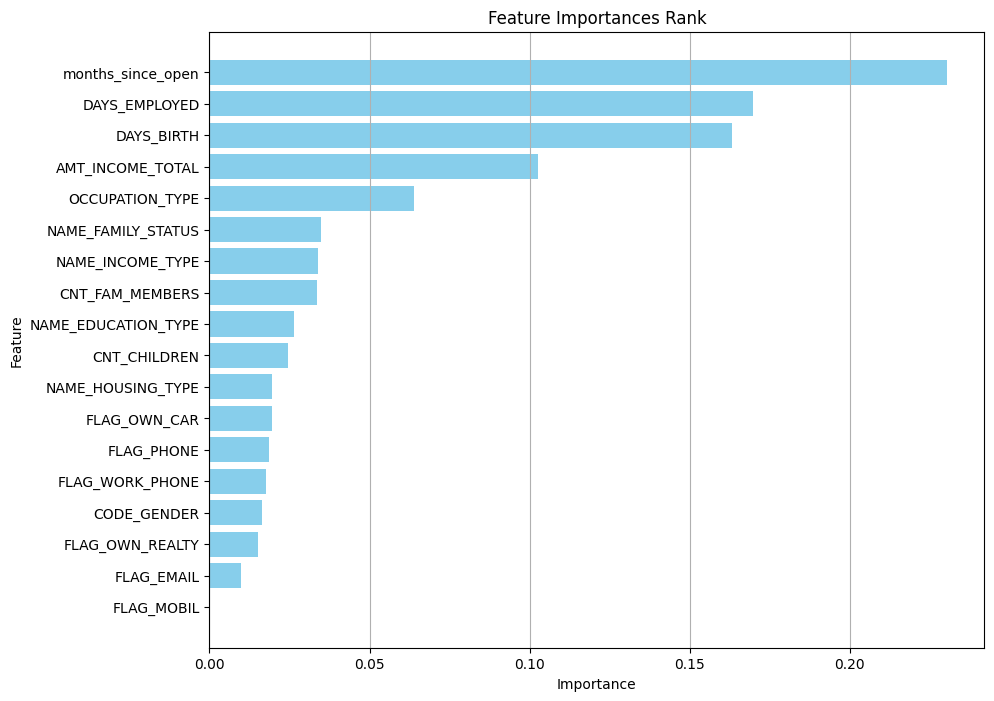

In [27]:
# Plot a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances Rank')
plt.grid(axis='x');

In [28]:
# Select features above a certain importance threshold (optional)
threshold = np.mean(feature_importances) 
selected_features = importance_df[importance_df['Importance'] > threshold]['Feature'].tolist()

print("Selected Features Above Threshold:\n", selected_features)

Selected Features Above Threshold:
 ['months_since_open', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'OCCUPATION_TYPE']


### Checking and Handling Outliers

In [29]:
df[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 25134 entries, 3217 to 45984
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   months_since_open  25134 non-null  int64  
 1   DAYS_EMPLOYED      25134 non-null  float64
 2   DAYS_BIRTH         25134 non-null  float64
 3   AMT_INCOME_TOTAL   25134 non-null  float64
 4   OCCUPATION_TYPE    25134 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.1 MB


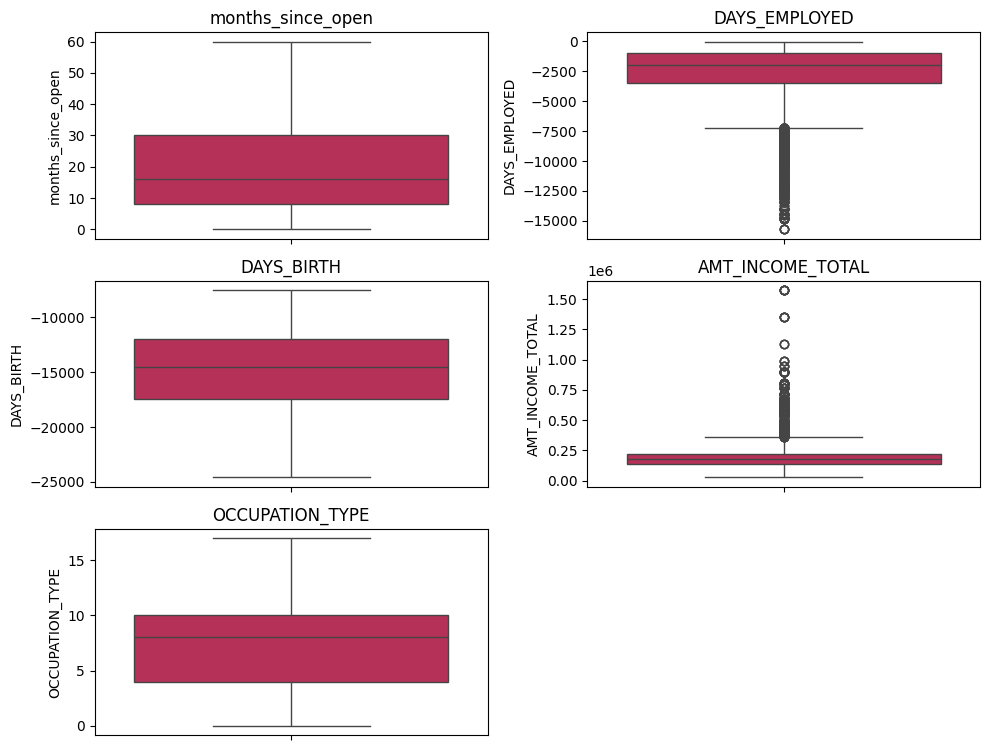

In [30]:
#Select numerical columns
numeric_columns = df[selected_features]
# Creating a figure with a 5x2 grid of subplots, setting the figure size to 10x15 inches.
fig, axes = plt.subplots(6, 2, figsize=(10, 15))
# Flattening the 2D grid of subplots into a 1D array for easier iteration.
axes = axes.flatten()
# Iterating through each numeric column, assigning its index to i and column name to col.
for i, col in enumerate(numeric_columns):
    # Creating a box plot for the current column on the corresponding subplot, using the 'rocket' color palette.
    sns.boxplot(data=df, y=col, ax=axes[i], palette='rocket')
    # Setting the title of the current subplot to the column name.
    axes[i].set_title(col)
# Iterating over the remaining subplots, starting from the next index after the last used subplot.
for j in range(i + 1, len(axes)):
    # Deleting the unused subplots to clean up the layout.
    fig.delaxes(axes[j])
# Automatically adjusting the layout to avoid overlapping elements.
plt.tight_layout();

**DAYS_EMPLOYED**

The `DAYS_EMPLOYED` feature contains clear outliers, most notably the value 365,243 (appearing 6135 times), which is an obvious anomaly. This value corresponds to approximately 1000 years, which is unrealistic.

IQR-based capping is a robust method to handle the outliers because it relies on percentiles and is less sensitive to extreme values compared to the mean and standard deviation. It ensures that outliers are not removed but are capped to reasonable limits, preserving the structure of the data.

In [31]:
df['DAYS_EMPLOYED'].describe()

count    25134.000000
mean     -2624.940877
std       2339.224822
min     -15713.000000
25%      -3484.000000
50%      -1942.000000
75%       -979.000000
max        -17.000000
Name: DAYS_EMPLOYED, dtype: float64

In [32]:
df[['DAYS_EMPLOYED']].value_counts()

DAYS_EMPLOYED
-401.0           64
-1539.0          62
-2087.0          53
-3234.0          51
-1678.0          51
                 ..
-4025.0           1
-4053.0           1
-4091.0           1
-4098.0           1
-15713.0          1
Name: count, Length: 3299, dtype: int64

In [33]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['DAYS_EMPLOYED'].quantile(0.25)
Q3 = df['DAYS_EMPLOYED'].quantile(0.75)

# Step 2: Calculate IQR
IQR = Q3 - Q1

# Step 3: Define lower and upper bounds for capping
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Apply capping to DAYS_EMPLOYED
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: max(min(x, upper_bound), lower_bound))

**AMT_INCOME_TOTAL**

We have decided to retain the outliers in the `AMT_INCOME_TOTAL` feature because high-income values, while less common, are realistic and represent an important customer segment, such as high-net-worth individuals. Removing these values could distort our analysis, as these clients likely have different financial behavior and lower credit risk. Similarly, the presence of low-income managers reflects real-world scenarios where entry-level, part-time, or small-business managers earn less than their senior counterparts. Retaining these outliers ensures a more comprehensive and accurate model, as it reflects the true diversity of income levels and managerial roles in the dataset.

In [34]:
df['AMT_INCOME_TOTAL'].describe()

count    2.513400e+04
mean     1.948339e+05
std      1.045110e+05
min      2.700000e+04
25%      1.350000e+05
50%      1.800000e+05
75%      2.250000e+05
max      1.575000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

In [35]:
df['AMT_INCOME_TOTAL'].value_counts()

AMT_INCOME_TOTAL
135000.0    3012
180000.0    2312
157500.0    2205
225000.0    2169
112500.0    1943
            ... 
160200.0       1
134995.5       1
164250.0       1
124200.0       1
179271.0       1
Name: count, Length: 195, dtype: int64

In [36]:
df1['OCCUPATION_TYPE'][df['AMT_INCOME_TOTAL'] == 27000].value_counts()

OCCUPATION_TYPE
Managers          2
Security staff    1
Name: count, dtype: int64

In [37]:
df1['OCCUPATION_TYPE'][df['AMT_INCOME_TOTAL'] == 1575000.0].value_counts()

OCCUPATION_TYPE
Managers    8
Name: count, dtype: int64

### Validating Outliers Post-Processing

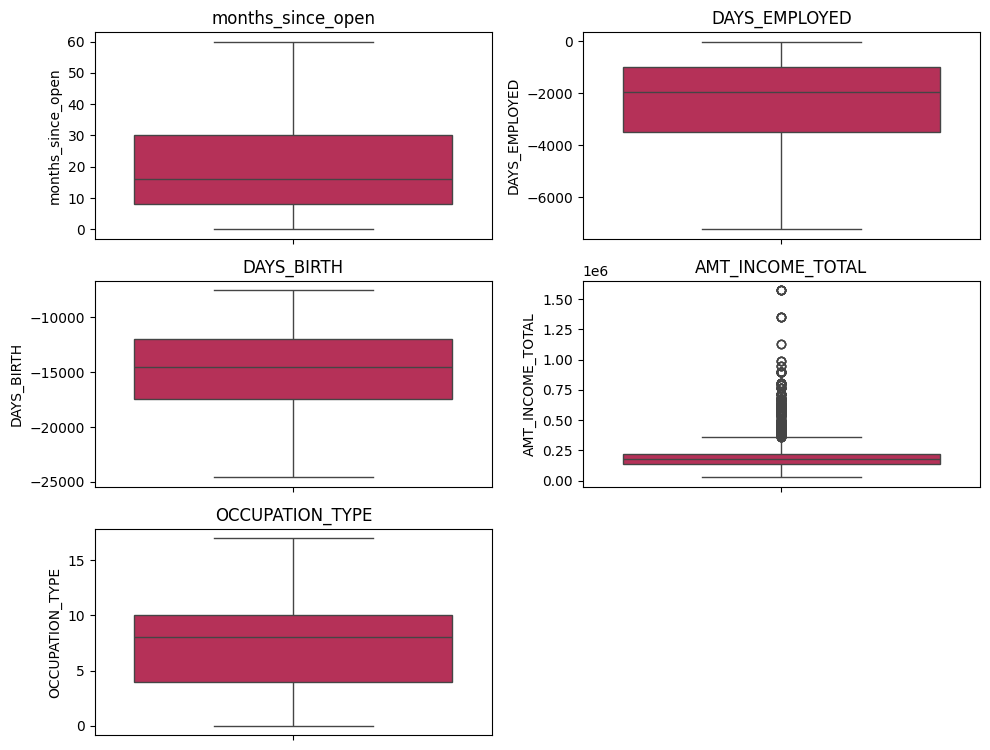

In [38]:
#Select numerical columns
numeric_columns = df[selected_features]
# Creating a figure with a 5x2 grid of subplots, setting the figure size to 10x15 inches.
fig, axes = plt.subplots(6, 2, figsize=(10, 15))
# Flattening the 2D grid of subplots into a 1D array for easier iteration.
axes = axes.flatten()
# Iterating through each numeric column, assigning its index to i and column name to col.
for i, col in enumerate(numeric_columns):
    # Creating a box plot for the current column on the corresponding subplot, using the 'rocket' color palette.
    sns.boxplot(data=df, y=col, ax=axes[i], palette='rocket')
    # Setting the title of the current subplot to the column name.
    axes[i].set_title(col)
# Iterating over the remaining subplots, starting from the next index after the last used subplot.
for j in range(i + 1, len(axes)):
    # Deleting the unused subplots to clean up the layout.
    fig.delaxes(axes[j])
# Automatically adjusting the layout to avoid overlapping elements.
plt.tight_layout();

### Handling Class Imbalance

- **Problem:** If one class (e.g., Risk Status = 1) is underrepresented, models might perform poorly on this minority class.
- **Solution:** ADASYN (Adaptive Synthetic Sampling) generates synthetic examples for the minority class, balancing the dataset.

In [39]:
X = df[selected_features]

In [40]:
# Apply ADASYN
adasyn = ADASYN(random_state=42)
X, y = adasyn.fit_resample(X, y)

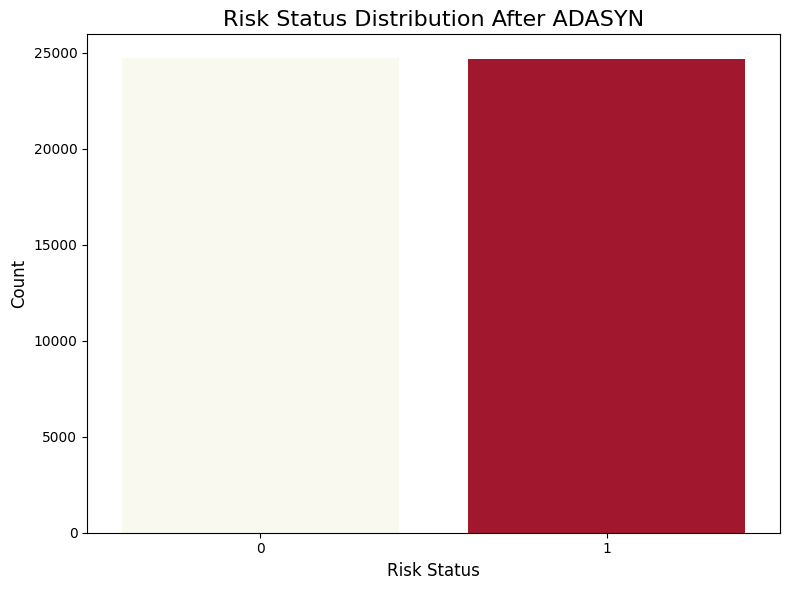

In [41]:
# Count the occurrences of each class in y after ADASYN
class_counts = Counter(y)

# Convert counts to a DataFrame for visualization
class_distribution = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
class_distribution.reset_index(inplace=True)
class_distribution.rename(columns={'index': 'Class'}, inplace=True)

# Create custom colors based on the class
colors = ['#B8001F' if cls == 1 else '#FCFAEE' for cls in class_distribution['Class']]

# Create a bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=class_distribution, x='Class', y='Count', palette=colors, hue='Class', legend=False)

plt.title('Risk Status Distribution After ADASYN', fontsize=16)
plt.xlabel('Risk Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout();


### Feature Scaling

- Purpose: Standardize the features to ensure all have the same scale.
- Standardizes the features to have a mean of 0 and a standard deviation of 1.



In [42]:
# Initialize StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Data Splitting
- Purpose: Divide the dataset into training and testing subsets.
- Splits the dataset into:
    - `X_train`, `y_train`: 70% of the data for training.
    - `X_test`, `y_test`: 30% of the data for testing.
- Ensures the model is evaluated on unseen data to measure generalization performance.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Training and Evaluation

Trains four models:
- Logistic Regression: Linear baseline model.
- Decision Tree: Baseline tree-based model.
- XGBoost: Gradient boosting model for capturing complex relationships.
- Random Forest: Ensemble model for robust predictions.

Evaluates models using:
- Accuracy, F1 Score, Precision, and Recall.

### Logistic Regression Model
- A baseline linear model that predicts the likelihood of risk status.


In [44]:
# Train a Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

#Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred)
f1_logreg = f1_score(y_test, y_pred, average='weighted')
precision_logreg = precision_score(y_test, y_pred, average='weighted')
recall_logreg = recall_score(y_test, y_pred, average='weighted')

print("Model Evaluation Metrics:")
print(f"Accuracy Score: {accuracy_logreg:.4f}")
print(f"F1 Score: {f1_logreg:.4f}")
print(f"Precision Score: {precision_logreg:.4f}")
print(f"Recall Score: {recall_logreg:.4f}")


Model Evaluation Metrics:
Accuracy Score: 0.6883
F1 Score: 0.6854
Precision Score: 0.6952
Recall Score: 0.6883


### Decision Tree Model
- A baseline tree-based algorithm that uses a hierarchical structure to make decisions by splitting data on feature values. 
- It is intuitive, handles non-linear relationships effectively, and serves as a foundation for more advanced ensemble methods like Random Forest and XGBoost. 

In [45]:
# Train a Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt.predict(X_test)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred)
f1_dt = f1_score(y_test, y_pred, average='weighted')
precision_dt = precision_score(y_test, y_pred, average='weighted')
recall_dt = recall_score(y_test, y_pred, average='weighted')

print("Decision Tree Model Evaluation Metrics:")
print(f"Accuracy Score: {accuracy_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"Precision Score: {precision_dt:.4f}")
print(f"Recall Score: {recall_dt:.4f}")


Decision Tree Model Evaluation Metrics:
Accuracy Score: 0.9578
F1 Score: 0.9578
Precision Score: 0.9579
Recall Score: 0.9578


### XGBoost Model
- A gradient boosting algorithm that builds decision trees sequentially, optimizing for model performance.
- Often performs well on structured data due to its ability to handle non-linear relationships and its robustness to overfitting.

In [46]:
# Train an XGBoost model
xgb = XGBClassifier(random_state=42) 
xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred, average='weighted')
precision_xgb = precision_score(y_test, y_pred, average='weighted')
recall_xgb = recall_score(y_test, y_pred, average='weighted')

print("Model Evaluation Metrics:")
print(f"Accuracy Score: {accuracy_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"Precision Score: {precision_xgb:.4f}")
print(f"Recall Score: {recall_xgb:.4f}")

Model Evaluation Metrics:
Accuracy Score: 0.9488
F1 Score: 0.9487
Precision Score: 0.9497
Recall Score: 0.9488


### Random Forest Model
- An ensemble model that builds multiple decision trees and averages their predictions.
- Reduces overfitting by aggregating the results of multiple trees.

In [47]:
# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred)
f1_rf = f1_score(y_test, y_pred, average='weighted')
precision_rf = precision_score(y_test, y_pred, average='weighted')
recall_rf = recall_score(y_test, y_pred, average='weighted')

print("Model Evaluation Metrics:")
print(f"Accuracy Score: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Precision Score: {precision_rf:.4f}")
print(f"Recall Score: {recall_rf:.4f}")

Model Evaluation Metrics:
Accuracy Score: 0.9820
F1 Score: 0.9820
Precision Score: 0.9821
Recall Score: 0.9820


### Model Comparison

Four machine learning models—Logistic Regression, Decision Tree, XGBoost, and Random Forest—were trained and evaluated to predict customer credit risk. Among these models:

- **Logistic Regression:** As a baseline linear model, it performed the weakest, with an accuracy of 68.83% and an F1 score of 0.6854, indicating its inability to capture non-linear relationships.
- **Decision Tree:** Achieved an accuracy and F1 score of 95.78%, demonstrating strong performance on the training data but with a risk of overfitting due to its structure.
- **XGBoost:** Delivered robust results with an accuracy of 94.87% and an F1 score of 0.9487, showing good generalization and the ability to handle non-linear patterns effectively.
- **Random Forest:** Outperformed all other models with an accuracy of 98.20% and an F1 score of 0.982, owing to its ensemble approach, which reduces overfitting and improves predictive reliability.

Given its superior metrics, the Random Forest model was selected as the best-performing model for detailed evaluation.



In [48]:
# Create a dictionary of results
results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest'],
    'Accuracy': [accuracy_logreg, accuracy_dt, accuracy_xgb, accuracy_rf],
    'F1 Score': [f1_logreg, f1_dt, f1_xgb, f1_rf],
    'Precision': [precision_logreg, precision_dt, precision_xgb, precision_rf],
    'Recall': [recall_logreg, recall_dt, recall_xgb, recall_rf]
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

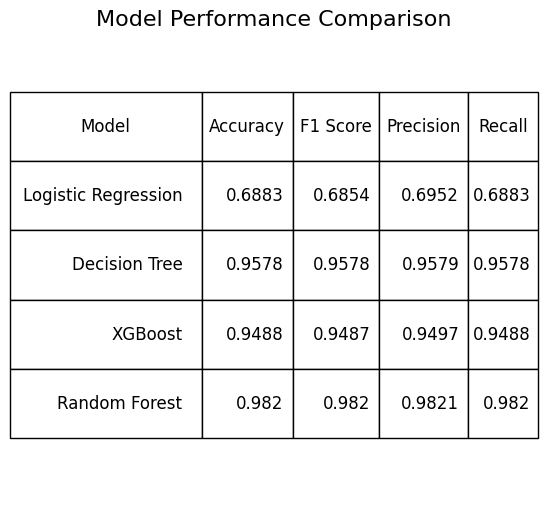

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))  # Increase the figure size
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(
    cellText=results_df.values, 
    colLabels=results_df.columns, 
    loc='center'
)

# Adjust font size and column width
table.auto_set_font_size(False)
table.set_fontsize(12)  # Adjust font size for better readability
table.auto_set_column_width(col=list(range(len(results_df.columns))))  # Automatically adjust column widths

# Adjust row heights to reduce overlap
for key, cell in table.get_celld().items():
    cell.set_height(0.15)  # Increase the cell height for better spacing

plt.title("Model Performance Comparison", fontsize=16);


### Detailed Analysis of Random Forest Model

**Model Metrics:**

- The Random Forest model achieved an accuracy of 98.20%, a precision of 0.9821, and a recall of 0.982, indicating exceptional performance in both identifying high-risk customers and minimizing false positives.
- The high F1 score of 0.982 confirms its balanced performance, effectively handling the class imbalance in the dataset.

**Confusion Matrix:**

The confusion matrix reveals:
- 7,325 high-risk customers were correctly identified, with only 89 misclassified as low-risk.
- 7,223 low-risk customers were correctly classified, with only 177 misclassified as high-risk.

These results demonstrate the model's effectiveness in distinguishing between low-risk and high-risk customers, critical for reducing defaults while avoiding unnecessary rejection of low-risk applicants.

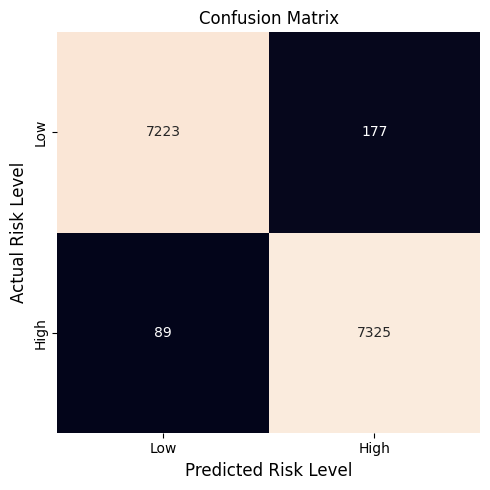

In [50]:
# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Confusion Matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'], cbar=False)
plt.title('Confusion Matrix', fontsize=12)
plt.xlabel('Predicted Risk Level', fontsize=12)
plt.ylabel('Actual Risk Level', fontsize=12)
plt.tight_layout();


**Cross-Validation Random Forest Model**

- Purpose: Validate the robustness of the Random Forest model and assess its generalizability to unseen data.
- The 5-fold cross-validation yielded a mean accuracy of 89.81% with a low standard deviation of 0.0159. This demonstrates that the model performs consistently across different subsets of the data, indicating that it is not overfitting to the training data.
- Overfitting occurs when a model performs exceptionally well on training data but poorly on validation or test data. The consistent accuracy observed during cross-validation confirms that the model maintains its performance across various splits, proving its ability to generalize effectively.
- These results reinforce the reliability of the Random Forest model, ensuring its suitability for deployment in real-world credit risk prediction tasks.

In [51]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))
print("Standard deviation:", np.std(cv_scores))

Cross-validation scores: [0.87150668 0.90259214 0.90988254 0.91646416 0.89013771]
Mean accuracy: 0.8981166464155528
Standard deviation: 0.015917607336943643


### Conclusion

The Random Forest model aligns seamlessly with the business need to predict credit risk accurately for credit card applicants. Its ability to classify customers effectively into low-risk and high-risk categories ensures financial institutions can:

- Reduce Defaults: By identifying high-risk customers, proactive measures can be implemented to mitigate default risks.
- Optimize Resource Allocation: Credit can be tailored more effectively to customers based on their risk profiles.
- Improve Decision-Making: The model's robustness ensures trust in automated credit approval decisions.

By leveraging historical payment behavior and demographic data, the Random Forest model fulfills the project objective of predicting the likelihood of customer default, enabling financial institutions to make data-driven, profitable decisions while minimizing risk exposure.